In [1]:

import os
import re
import sys
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore')

os.makedirs('./figures', exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./result/ftmle', exist_ok=True)

In [9]:
def extract_values(sentence, pattern):
    match = re.match(pattern, sentence) 
    if match:
        return match
    else:
        return None
    
def read_log(infile, T, epoch, interval=0.2):
    m_pattern = r"~~~~Start training a new model with F = (\d+\.\d+) iteration = (\d+\.\d+) ~~~~"
    v_pattern = r"==>>> epoch: (\d+), test loss: (\d+\.\d+|nan), acc: (\d+\.\d+)"
    T = int(T/interval)
    iteration = 0
    force = 0

    loss, accuracy = [], []
    losses, accuracies = [[] for _ in range(T)], [[] for _ in range(T)]

    with open(infile) as f:
        f = f.readlines()
        for line in f:
            m_result = extract_values(line, m_pattern)
            v_result = extract_values(line, v_pattern)
            if m_result:
                if force != 0 and iteration != 0:
                    assert len(loss) == epoch
                    assert len(accuracy) == epoch
                    losses[iteration-1].append(loss)
                    accuracies[iteration-1].append(accuracy)
                force = float(m_result.group(1)) if force == 0 else force
                iteration = round(float(m_result.group(2))/interval)
                loss, accuracy = [], []
            elif v_result:
                loss_val = v_result.group(2)
                loss.append(float(loss_val) if loss_val != 'nan' else sys.float_info.max)
                accuracy.append(float(v_result.group(3)))
        losses[iteration-1].append(loss)
        accuracies[iteration-1].append(accuracy)
    return np.array(losses), np.array(accuracies)

def get_index_within_tolerance(array, tolerance=0.0005):
    # Calculate the minimum value along dim=epoch
    max_values = np.max(array, axis=2, keepdims=True)
    # Calculate the upper bound within the given 1% tolerance
    lower_bound = max_values - tolerance
    # Select divergence region
    div_mask = np.any(max_values <= 0.12, axis=1).squeeze()
    # Mask where the values are within the tolerance and then get the indices
    mask = array >= lower_bound
    indices = np.argmax(mask, axis=2)
    # Return the average index among dim=5
    avg_indices = indices.mean(axis=1)
    avg_indices[div_mask] = None
    return avg_indices

In [10]:
fs = np.round(np.linspace(0.25, 10, 40), 2)
iteration_headers = np.round(np.linspace(0.2, 5, 25), 2).tolist()
avg_accuracy_result, max_accuracy_result= [], []
avg_epoch_result = []
for f in fs:
    losses, accuracies = read_log(f'./log/lorenz_f{f:.2f}.log', T=5, epoch=20)
    avg_accuracy = np.mean(accuracies.max(axis=2), axis=1)
    max_accuracy = accuracies.max(axis=2).max(axis=1)
    avg_accuracy_result.append(avg_accuracy)
    max_accuracy_result.append(max_accuracy)
    avg_epochs = get_index_within_tolerance(accuracies)
    avg_epoch_result.append(avg_epochs)
avg_accuracy_result = np.stack(avg_accuracy_result)
max_accuracy_result = np.stack(max_accuracy_result)
avg_epoch_result = np.stack(avg_epoch_result)

In [12]:
# expanded_rho = np.repeat(fs[:, np.newaxis], 25, axis=1).flatten()
accuracy_df = pd.DataFrame(avg_accuracy_result, columns=iteration_headers)
accuracy_df['f'] = fs
accuracy_df = accuracy_df[['f'] + iteration_headers]
accuracy_df = accuracy_df.iloc[::-1].reset_index(drop=True)
accuracy_df

,f,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,...,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
0,10.00,0.97990,0.97876,0.97974,0.97902,0.97916,0.97636,0.96924,0.96774,0.96270,...,0.52862,0.50526,0.43796,0.37302,0.31762,0.16324,0.09800,0.09800,0.09800,0.09800
1,9.75,0.97894,0.97850,0.97922,0.97838,0.97920,0.97720,0.97140,0.96656,0.96484,...,0.57390,0.54462,0.45788,0.41792,0.36236,0.25804,0.09800,0.09800,0.09800,0.09800
2,9.50,0.97898,0.97972,0.97886,0.97888,0.97900,0.97726,0.97200,0.96820,0.96666,...,0.58342,0.56028,0.50782,0.46676,0.41090,0.36680,0.15652,0.09800,0.09800,0.09800
3,9.25,0.97956,0.97834,0.97868,0.97960,0.97918,0.97728,0.97328,0.96876,0.96624,...,0.61194,0.57622,0.53524,0.50540,0.44254,0.39996,0.30120,0.09800,0.09800,0.09800
4,9.00,0.97902,0.97852,0.97912,0.97888,0.97884,0.97880,0.97378,0.96874,0.96540,...,0.65082,0.60738,0.57866,0.53806,0.47950,0.43682,0.40548,0.12744,0.09800,0.09800
5,8.75,0.97868,0.97944,0.97934,0.97898,0.97958,0.97840,0.97504,0.96838,0.96706,...,0.66076,0.63432,0.60912,0.57472,0.51268,0.47674,0.41588,0.14946,0.09800,0.09800
6,8.50,0.97880,0.97876,0.97914,0.97934,0.97910,0.97854,0.97710,0.97034,0.96744,...,0.66984,0.65804,0.65104,0.61406,0.55528,0.54680,0.47634,0.21370,0.09800,0.09800
7,8.25,0.97920,0.97908,0.97954,0.97910,0.97926,0.97928,0.97648,0.97064,0.96836,...,0.70818,0.65966,0.67694,0.63110,0.60748,0.54370,0.50966,0.45662,0.13762,0.09800
8,8.00,0.97936,0.97950,0.97900,0.97984,0.97916,0.97906,0.97700,0.97106,0.96900,...,0.76304,0.69406,0.69016,0.66552,0.63038,0.58458,0.56228,0.44130,0.24338,0.09800
9,7.75,0.97912,0.97960,0.97854,0.97898,0.97990,0.97948,0.97838,0.97342,0.96930,...,0.81204,0.73162,0.71158,0.70086,0.66710,0.65004,0.62268,0.56408,0.41864,0.09800


In [25]:
epochs_df = pd.DataFrame(avg_epoch_result, columns=iteration_headers)
epochs_df['f'] = fs
epochs_df = epochs_df[['f'] + iteration_headers]
epochs_df = epochs_df.iloc[::-1].reset_index(drop=True)
epochs_df


,f,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,...,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
0,10.00,18.0,14.0,16.4,17.4,17.4,14.6,14.6,16.6,16.6,...,15.4,12.0,12.0,10.4,8.6,NaN,NaN,NaN,NaN,NaN
1,9.75,18.6,14.4,17.0,16.4,16.4,15.4,16.4,17.2,16.4,...,15.2,14.6,15.8,10.8,6.4,NaN,NaN,NaN,NaN,NaN
2,9.50,17.4,16.8,15.8,17.4,15.0,15.2,14.6,14.6,17.8,...,14.0,16.0,11.6,11.4,9.0,6.2,NaN,NaN,NaN,NaN
3,9.25,17.4,17.0,16.4,18.2,16.0,15.0,13.4,15.6,16.6,...,15.4,15.0,12.6,13.0,9.6,8.0,1.0,NaN,NaN,NaN
4,9.00,19.0,15.6,13.6,16.8,16.0,16.0,15.6,17.8,16.0,...,17.4,12.8,13.8,10.8,9.8,9.0,4.8,NaN,NaN,NaN
5,8.75,16.6,15.6,16.8,14.8,15.6,12.8,15.0,13.2,15.2,...,16.0,16.8,14.0,12.8,11.0,9.4,5.2,NaN,NaN,NaN
6,8.50,17.6,14.0,16.0,15.6,16.2,14.8,15.4,17.6,12.2,...,16.4,12.4,12.8,13.8,9.2,8.4,6.6,NaN,NaN,NaN
7,8.25,17.2,16.8,15.4,16.2,15.8,15.4,15.4,14.0,12.6,...,16.2,13.6,15.2,14.6,11.8,8.8,9.0,4.6,NaN,NaN
8,8.00,19.0,16.2,14.0,17.4,14.0,16.0,15.8,12.0,14.8,...,16.6,14.8,15.2,13.0,13.0,9.0,6.6,NaN,NaN,NaN
9,7.75,18.4,16.4,14.0,15.2,17.6,13.0,14.6,14.0,16.2,...,18.0,15.4,16.6,14.6,13.6,14.6,11.2,8.4,NaN,NaN


In [27]:
accuracy_df.to_csv('./result/mnist_avg_accuracy.csv', index=False)
epochs_df.to_csv('./result/mnist_avg_epoch.csv', index=False)

### 1. Plot accuracy colormap

In [11]:
Fs = np.round(np.linspace(4.0, 10.0, 25), 2)

MLE = [
    0.009736563075138276, # F = 4.0
    0.012248702894949863,
    0.02420281446430927,
    0.048604922776931764,
    0.3946948984932183,
    0.6019308138163472,
    0.7280386585882023,
    0.8559802814078066,
    0.9609543191276696,
    1.0685067631099594,
    1.1829015070124658,
    1.259945198299732,
    1.362731019020557,
    1.44687365250258,
    1.561375051645095,
    1.624984647151513,
    1.7094105283445578,
    1.8259014160581808,
    1.8985022916367142,
    1.980917920782985,
    2.041617665006157,
    2.1268493185260557,
    2.2119887255181263,
    2.286734419188884,
    2.3923529404058215
]

MLE = np.array(MLE)
# up = np.array(up)
# low = np.array(low)
lyapunov_time = 1/MLE
# lt_up = 1/up
# lt_low = 1/low
# print(lyapunov_time)

lyapunov_time_df = pd.DataFrame.from_dict({"F": [], "Iteration Time": []})

for i in range(len(lyapunov_time)):
    data_to_append = pd.DataFrame({
        "F": [str(Fs[i])],
        "Iteration Time": [lyapunov_time[i]*4],
    })
    lyapunov_time_df = pd.concat([lyapunov_time_df, data_to_append], ignore_index=True)
lyapunov_time_df = lyapunov_time_df.iloc[::-1].reset_index(drop=True)
lyapunov_time_df

,F,Iteration Time
0,10.0,1.671994
1,9.75,1.749219
2,9.5,1.808327
3,9.25,1.880716
4,9.0,1.959231
5,8.75,2.019266
6,8.5,2.106924
7,8.25,2.190699
8,8.0,2.339988
9,7.75,2.461562


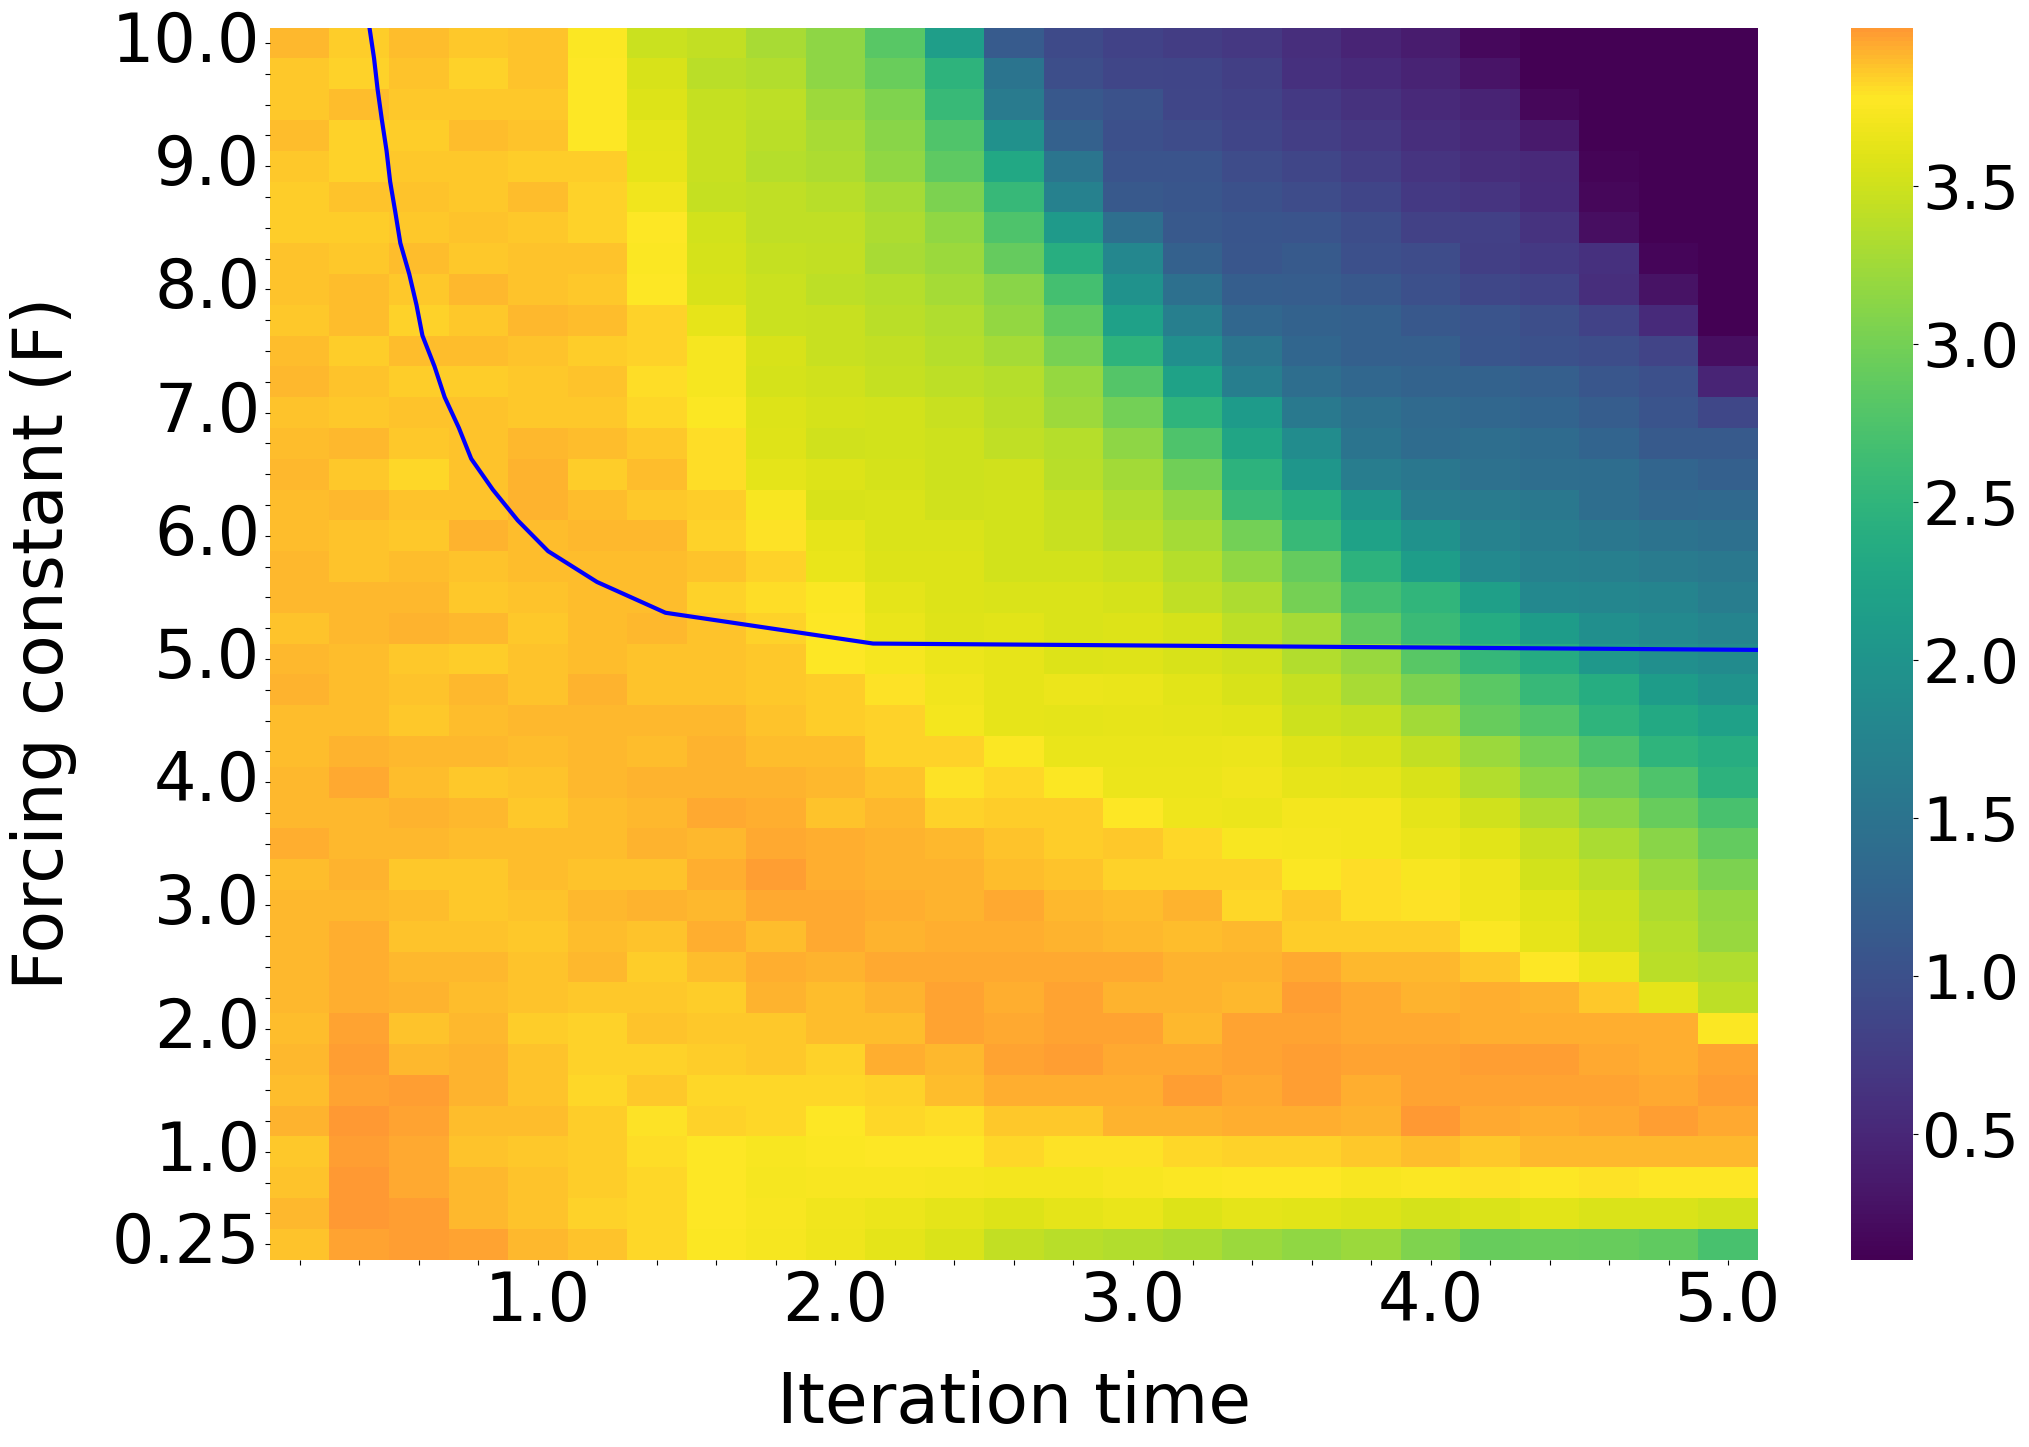

In [35]:
avg_accuracy_df = pd.read_csv('./result/mnist_avg_accuracy.csv', skiprows=1, header=None, index_col=0)
esn_error_df = -np.log(1 - avg_accuracy_df)

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)

viridis_colors = plt.cm.viridis(np.linspace(0, 1, 256))
light_orange = np.array([1, 0.6, 0.2, 1])

n_extend = 16  # number of colors to interpolate
extended_colors = np.vstack([viridis_colors, 
                             np.array([np.linspace(viridis_colors[-1][i], light_orange[i], n_extend) for i in range(4)]).T])
extended_viridis = ListedColormap(extended_colors)

g1 = sns.heatmap(esn_error_df, cmap=extended_viridis, xticklabels=iteration_headers, yticklabels=True, ax=ax)
plt.xticks(rotation=0) 
# ax_twin = ax.twinx()

for item in g1.get_xticklabels():
    item.set_rotation(0)
for item in g1.get_yticklabels():
    item.set_rotation(0)

g2 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="F",
                  linewidth=3, markersize=3, color="blue")

# lyapunov_time = lyapunov_time[::-1]
# for _ in range(9):
#     lyapunov_time = np.append(lyapunov_time, lyapunov_time[-1]*10)

# x = sp_range[::-1]
# for i in range(len(x)):
#     x[i] = x[i] 

# ax_twin.plot(lyapunov_time, x, marker='o', linestyle='-')
        
g1.set_xlabel("Iteration time", fontsize=50, labelpad=25)
g1.set_ylabel("Forcing constant (F)", fontsize=50, labelpad=25)
g1.tick_params(axis='both', labelsize=48)

cbar = g1.collections[0].colorbar
cbar.ax.tick_params(labelsize=44)

for ind, label in enumerate(g1.get_yticklabels()):
    if (ind) % 4 == 0 or ind==39:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

for ind, label in enumerate(g1.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

# plt.title("MNIST Testing Error w.r.t Spectral Radius and Iteration Step", y=-0.12)
# plt.show()
plt.savefig("./figures/lorenz_mnist_accuracy.eps", format="eps", transparent=True)


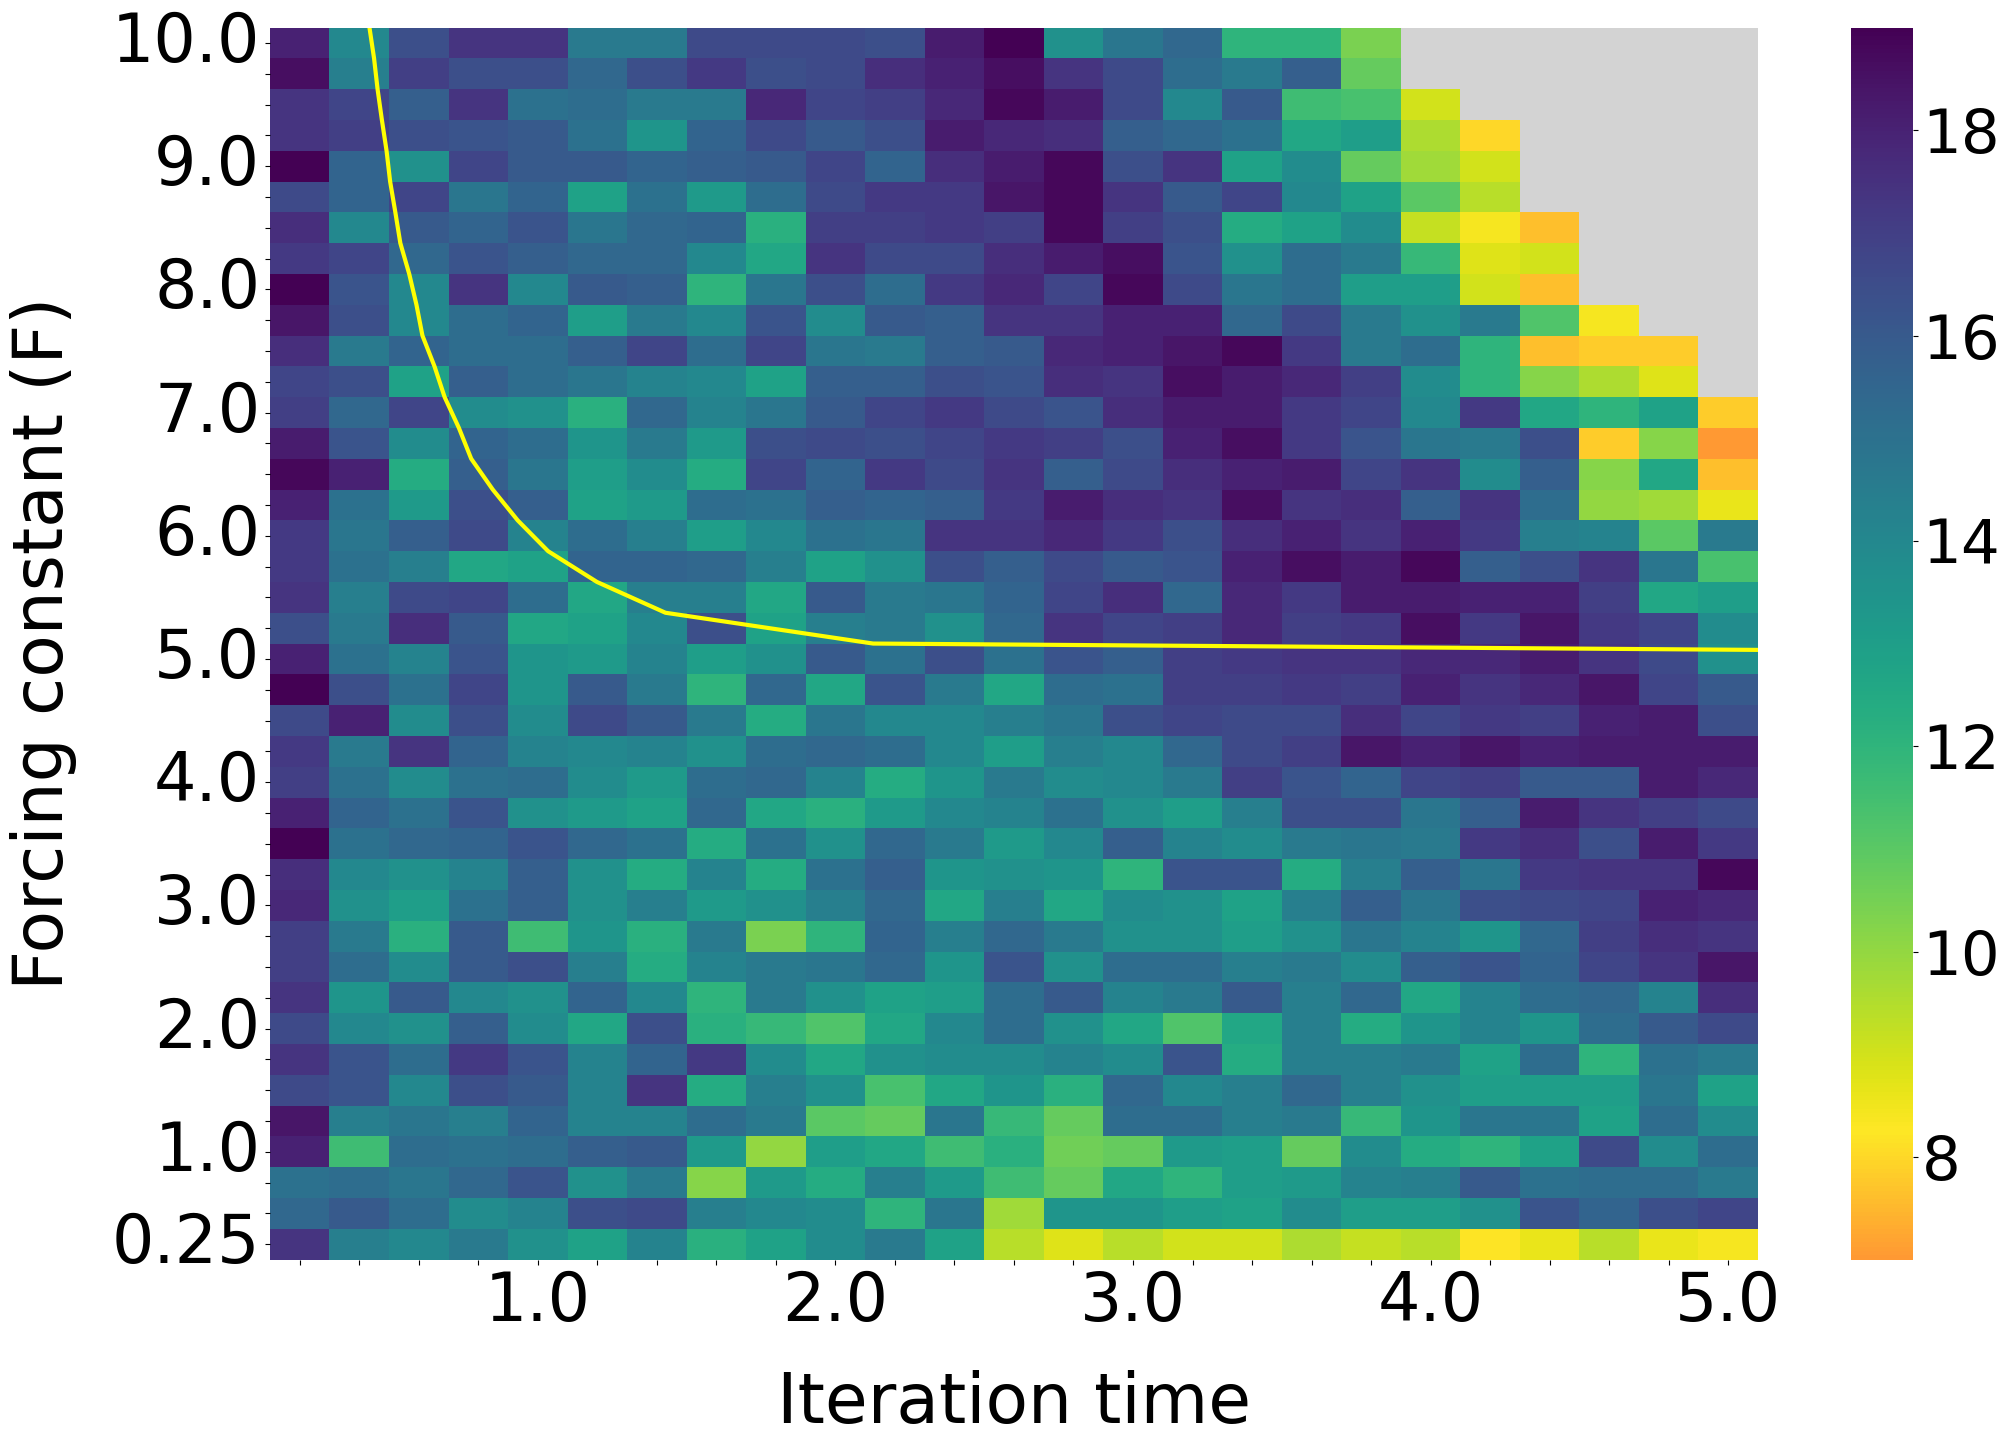

In [34]:
avg_epochs_df = pd.read_csv('./result/mnist_avg_epoch.csv', skiprows=1, header=None, index_col=0)
mask = avg_accuracy_df <= 0.12
avg_epochs_df[mask] = None

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)

viridis_r_colors = plt.cm.viridis_r(np.linspace(0, 1, 256))
light_orange = np.array([1, 0.6, 0.2, 1])

n_extend = 30  # number of colors to interpolate
extended_colors = np.vstack([np.array([np.linspace(light_orange[i], viridis_r_colors[0][i], n_extend) for i in range(4)]).T,
                             viridis_r_colors])
extended_viridis = ListedColormap(extended_colors)

extended_viridis.set_bad(mcolors.to_rgba('lightgrey'))

g1 = sns.heatmap(avg_epochs_df, cmap=extended_viridis, xticklabels=iteration_headers, yticklabels=True, ax=ax)
plt.xticks(rotation=0) 
# ax_twin = ax.twinx()

for item in g1.get_xticklabels():
    item.set_rotation(0)
for item in g1.get_yticklabels():
    item.set_rotation(0)

for ind, label in enumerate(g1.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(g1.get_yticklabels()):
    if (ind) % 4 == 0 or ind==39:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
g2 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="F",
                  linewidth=3, markersize=3, color="yellow")

# lyapunov_time = lyapunov_time[::-1]
# for _ in range(9):
#     lyapunov_time = np.append(lyapunov_time, lyapunov_time[-1]*10)

# x = sp_range[::-1]
# for i in range(len(x)):
#     x[i] = x[i] 

# ax_twin.plot(lyapunov_time, x, marker='o', linestyle='-')
        
g1.set_xlabel("Iteration time", fontsize=50, labelpad=25)
g1.set_ylabel("Forcing constant (F)", fontsize=50, labelpad=25)
g1.tick_params(axis='both', labelsize=48)
cbar = g1.collections[0].colorbar
cbar.ax.tick_params(labelsize=44)
# plt.title("MNIST Testing Error w.r.t Spectral Radius and Iteration Step", y=-0.12)
# plt.show()
plt.savefig("./figures/lorenz_mnist_training_epoch.eps", format="eps", transparent=True)

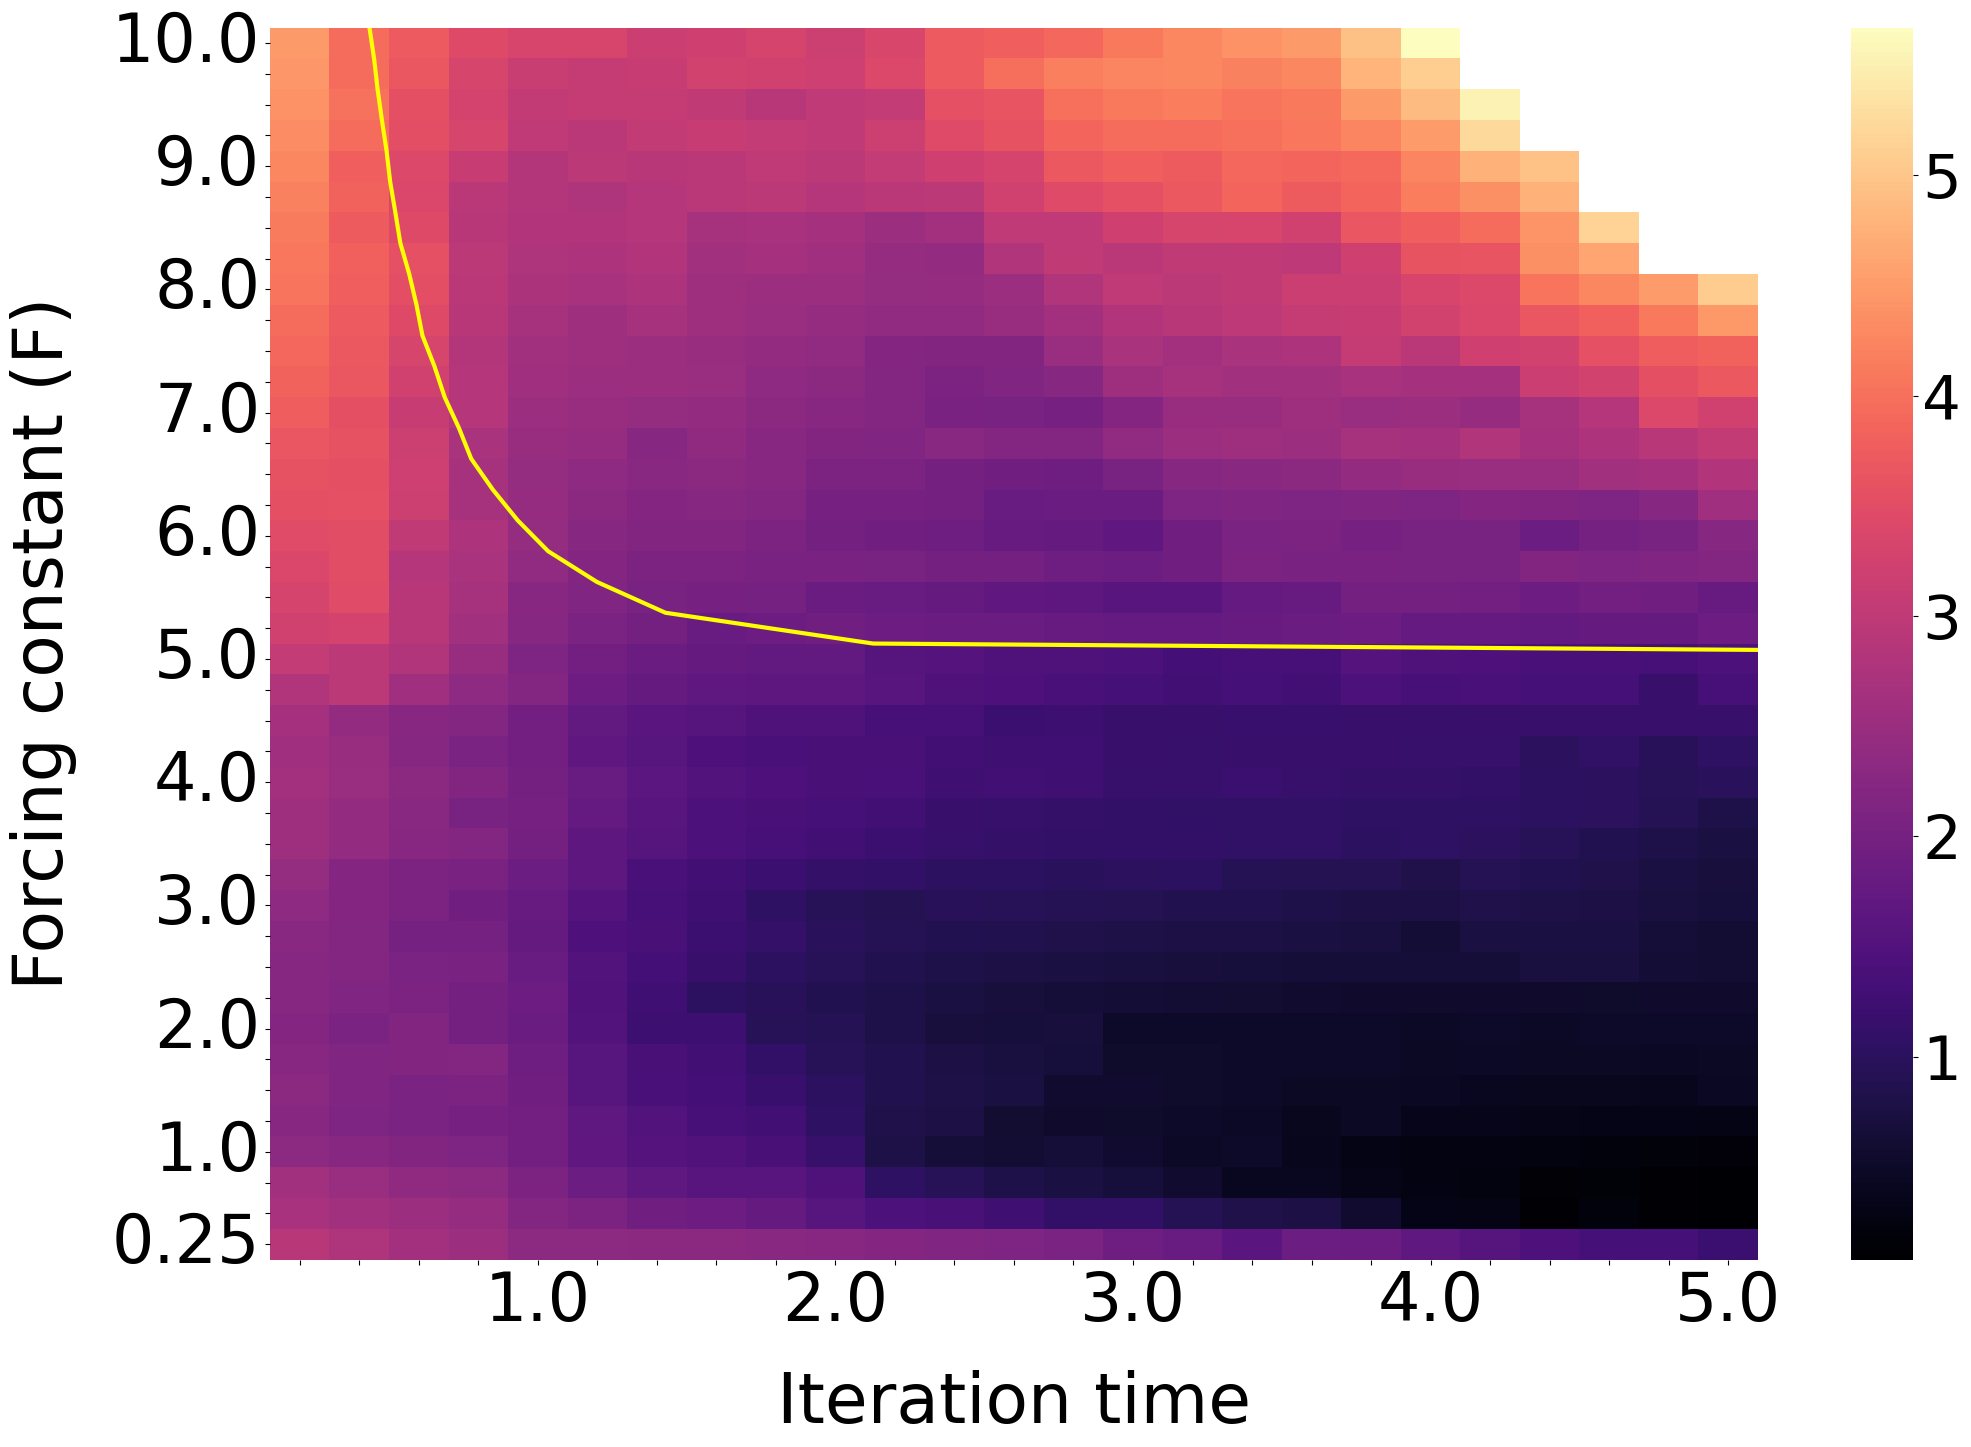

In [33]:
avg_ftmle_df = pd.read_csv('./result/mnist_avg_ftmle.csv', skiprows=1, header=None, index_col=0)
avg_ftmle_df = avg_ftmle_df.iloc[::-1]

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)

g1 = sns.heatmap(avg_ftmle_df, cmap='magma', xticklabels=iteration_headers, yticklabels=True, ax=ax)
plt.xticks(rotation=0) 
# ax_twin = ax.twinx()

for item in g1.get_xticklabels():
    item.set_rotation(0)
for item in g1.get_yticklabels():
    item.set_rotation(0)

g2 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="F",
                  linewidth=3, markersize=3, color="yellow")
        
g1.set_xlabel("Iteration time", fontsize=50, labelpad=25)
g1.set_ylabel("Forcing constant (F)", fontsize=50, labelpad=25)
g1.tick_params(axis='both', labelsize=48)

cbar = g1.collections[0].colorbar
cbar.ax.tick_params(labelsize=44)

for ind, label in enumerate(g1.get_yticklabels()):
    if (ind) % 4 == 0 or ind==39:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

for ind, label in enumerate(g1.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

# plt.title("MNIST Testing Error w.r.t Spectral Radius and Iteration Step", y=-0.12)
# plt.show()
plt.savefig("./figures/lorenz_mnist_ftmle.eps", format="eps", transparent=True)
